<a href="https://colab.research.google.com/github/littlekii/DPBBP/blob/main/mc_dropout_hetero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install GPy

import pandas as pd
import zipfile
import urllib.request
import os
import GPy
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

ERROR: torch-0.4.1-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     |████████████████████████████████| 962kB 4.3MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565026 sha256=a1228882a82c85d4819d30c68f1b75ec7829f0a98e1dc65efe780da3b76fbbbe
  Stored in directory: /root/.cache/pip/wheels/23/99/8d/d0c3dee7db4af58190cde6abdb45e6a7ded2f9f01ff528dd0f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102566 sha256=0aac6dd0daca92cc01a494cdd6a772e0971cd81dd8f48252d8044603ce2b9b3a
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [ ]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'Tesla P100-PCIE-16GB'

In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [ ]:
def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()
        

In [ ]:
class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, 2*output_dim)
        
        self.activation = nn.ReLU(inplace = True)

    
    def forward(self, x):
        
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer2(x)
        
        return x

In [ ]:
class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        
        output = self.network(x)
        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
        
        loss.backward()
        self.optimizer.step()

        return loss, output[:, :1]
    
    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())
        
        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1)**2)**0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)
        
        rmse = ((mean - y)**2).mean()**0.5

        return loss.detach().cpu(), rmse.detach().cpu()

In [ ]:
np.random.seed(5)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

print(x_train.shape, y_train.shape)
num_epochs, batch_size = 2000, len(x_train)

net = MC_Dropout_Wrapper(network=MC_Dropout_Model(input_dim=1, output_dim=1, num_units=200, drop_prob=0.5),
                         learn_rate=1e-4, batch_size=batch_size, weight_decay=1e-2)

fit_loss_train = np.zeros(num_epochs)
best_net, best_loss = None, float('inf')
nets, losses = [], []

for i in range(num_epochs):
    
    loss = net.fit(x_train, y_train)[0]
    y_hat = net.fit(x_train, y_train)[1] 
    if i % 200 == 0:
        print('Epoch: %4d, Train loss = %7.3f' % (i, loss.cpu().data.numpy()/batch_size))

(250, 1) (250, 1)
Epoch:    0, Train loss =   2.090
Epoch:  200, Train loss =   0.958
Epoch:  400, Train loss =   0.914
Epoch:  600, Train loss =   0.926
Epoch:  800, Train loss =   1.065
Epoch: 1000, Train loss =   0.886
Epoch: 1200, Train loss =   0.854
Epoch: 1400, Train loss =   0.901
Epoch: 1600, Train loss =   0.887
Epoch: 1800, Train loss =   0.899


In [ ]:
np.power((y_hat.cpu().data.numpy()-y_train),2).sum()/250


0.5757621960043432

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

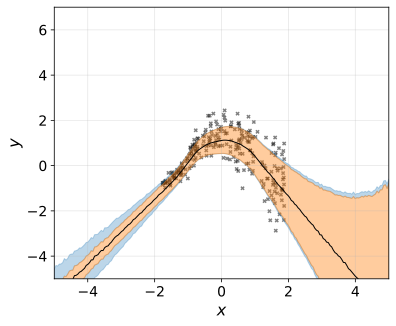

In [ ]:
samples = []
noises = []
for i in range(1000):
    preds = net.network.forward(torch.linspace(-5, 5, 200).cuda()).cpu().data.numpy()
    samples.append(preds[:, 0])
    noises.append(np.exp(preds[:, 1]))
    
samples = np.array(samples)
noises = np.array(noises)
means = (samples.mean(axis = 0)).reshape(-1)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = (samples.var(axis = 0)**0.5).reshape(-1)
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train, y_train, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200), means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200), means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200), means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200), means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16)
#plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2),fontsize=14)
plt.yticks(np.arange(-4, 7, 2),fontsize=14)
#plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('mcd_hetero.pdf', bbox_inches = 'tight')

files.download("mcd_hetero.pdf")

plt.show()